# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

**Papers used:**
http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf
http://people.idsia.ch/~juergen/nn2012traffic.pdf
http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf
https://arxiv.org/pdf/1511.02992.pdf

**Links:**
https://www.quora.com/Why-does-batch-normalization-help
https://pgaleone.eu/deep-learning/regularization/2017/01/10/anaysis-of-dropout/

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import csv
# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = format(X_train[0].shape)

# TODO: How many unique classes/labels there are in the dataset.
from numpy import recfromcsv
class_data = recfromcsv('signnames.csv', delimiter=',')

n_classes = len(class_data)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
# Libraries used
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from pprint import pprint
import matplotlib.gridspec as gridspec
from collections import defaultdict
from random import randint
from sklearn.utils import shuffle
import tensorflow as tf
from skimage import exposure
from skimage.color import rgb2gray
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.contrib.layers import flatten
from IPython.display import clear_output, Image, display, HTML

# Visualizations will be shown in the notebook.
%matplotlib inline

In [4]:
#Define Functions

#This transform_image code was taken by suggestion in the udacity forum, written by udacity member vivek yadav
#https://github.com/vxy10/ImageAugmentation
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''    
    
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img  
        
def plotImageByIndex(index):
    plt.suptitle(class_data[y_train[index]])
    plt.imshow(X_train[index])
    
def showImageGrid(images,x,y,labels = []):
    gs1 = gridspec.GridSpec(x, y)
    gs1.update(wspace=0.00, hspace=0.00) # set the spacing between axes. 
    plt.figure(figsize=(8,8))
    for i in range(len(images)):
        ax1 = plt.subplot(gs1[i])
        if len(labels) == len(images):
            print(labels[i])
            ax1.set_title(labels[i])
        plt.subplot(x,y,i+1)
        plt.imshow(images[i])
        plt.axis('off')

    plt.show()

def generateCountMap(X,y):
    countMap = defaultdict(list)
    for i in range(len(X)):
        index = y[i] 
        countMap[index].append(i)
    return countMap

def generateValueCountMap(countMap):
    valueCountMap = dict.fromkeys(list(range(n_classes)),list())
    for i in range(n_classes):
        valueCountMap[i] = len(countMap[i])
    return valueCountMap

def printClassSamples(X,y,minValue):
    #print all classes once from a random sample slice
    countMap = generateCountMap(X,y);
    each_class_sample = [item[randint(0,minValue)] for item in countMap.values()]
    sample_images = []
    sample_labels = []
    count = 0
    for sample in each_class_sample:
        sample_images.append(X[sample])
        count += 2
    showImageGrid(sample_images,5,10, sample_labels)

def minmax(X):
    current_min = np.min(X)
    current_max = np.max(X)
    X = (X - current_min) / (current_max - current_min)
    return X

def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)
    
def print_activations(temp, do=True):
    if do:
        print(temp.op.name, ' ', temp.get_shape().as_list())
        
def printDistribution(X,y_,label):
    countMap = generateCountMap(X,y_)
    valueCountMap = generateValueCountMap(countMap)

    #show distribution of values in plot
    plt.rcdefaults()
    fig, ax = plt.subplots(nrows=1, ncols=1)
    classes = list(zip(*class_data))[0]
    number = list(valueCountMap.values())
    y_pos = np.arange(n_classes)
    ax.barh(y_pos, number,color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(classes)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Number of samples')
    ax.set_title('Distribution of ' + label + ' samples')
    ax.tick_params(axis='both', length=8, labelsize=8)
    fig.tight_layout()
    plt.show()

    #distribution shows inbalanced data, so generate equal data for all signs
    maxValue = max(valueCountMap.values())
    print('Maximum number of values on a class: ', maxValue)
    minValue = min(valueCountMap.values())
    print('Minimum number of values on a class: ', minValue)
    average = (int) (sum(valueCountMap.values())/n_classes)
    print('Average number of values on a class: ', average)
    return minValue,maxValue,average

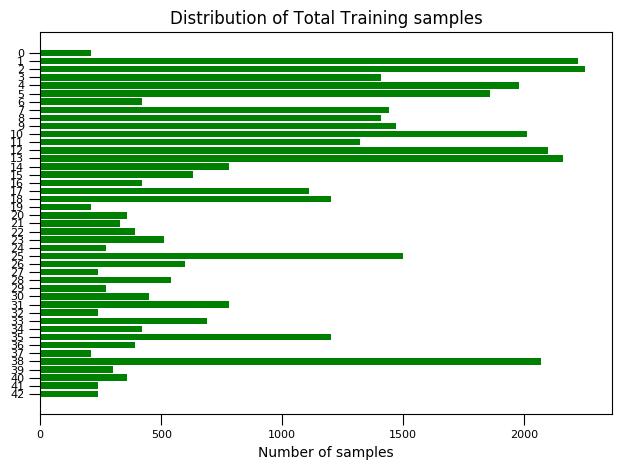

Maximum number of values on a class:  2250
Minimum number of values on a class:  210
Average number of values on a class:  911


In [5]:

### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
minValue, maxValue, average = printDistribution(X_train,y_train, 'Total Training')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

In [6]:
### Generate data additional data (OPTIONAL!)
#for each class add the number of missing labeled data up to maxValue by generating new transformed images 
#of existing labeled data, so that from each class exists the same number of samples
def fillTrainingSet(X,y_,class_index,number,listTrainingIndexes):
    x = np.zeros((number, 32, 32, 3), dtype=X.dtype)
    y = np.zeros((number), dtype=y_.dtype)
    
    #create number times transformed images of the given class
    for i in range(number):
        randomIndex = listTrainingIndexes[randint(0,10)]
        
        #get a random sample sign image of this index
        image = X[randomIndex]
    
        #transform this sample image
        img = transform_image(image,20,10,5)
        x[i] = img
        y[i] = class_index
    return x,y

def createJitterImages(X, y_, addJitterData = False, num = 300):  
    fillMissing = False
    fillAll = True
    #Fill up missing values
    if addJitterData:
        if fillMissing:
            countMap = generateCountMap(X,y_)
            valueCountMap = generateValueCountMap(countMap)
            maxValue = max(valueCountMap.values())
            print('maximum value: ', maxValue)
            
            for i in range(n_classes):
                missing = np.absolute(valueCountMap[i] - maxValue)
                print('Generating missing values for sign index ', i, ' = ', missing)
                x,y = fillTrainingSet(X,y_,i,missing,countMap[i])
                if len(x) == 0:
                    continue
                X = np.concatenate((X, x), axis=0)
                y_ = np.concatenate((y_, y), axis=0)

        if fillAll:
            #Add from each class type num generated jittered images
            countMap = generateCountMap(X,y_)
            valueCountMap = generateValueCountMap(countMap)
            print('Generating additional ', num, ' images from each of the ', n_classes, ' classes')
            for i in range(n_classes):
                x,y = fillTrainingSet(X,y_,i,num,countMap[i])
                X = np.concatenate((X, x), axis=0)
                y_ = np.concatenate((y_, y), axis=0)
        
    return X,y_
    

In [7]:
def createBalancedTrainingSet(X,y_,number):
    countMap = generateCountMap(X,y_)
    valueCountMap = generateValueCountMap(countMap)
    n_classes = len(valueCountMap.keys())

    minValue = min(valueCountMap.values())
   
    X_bal = np.empty((number * n_classes, 32, 32, 3), dtype=X.dtype)
    y_bal = np.empty((number* n_classes), dtype=y_.dtype)

    #for each class
    for clazz in range(n_classes):    
        for i in range(number):
            if i >= valueCountMap[clazz]:
                #print('Stopping at ', i, ' for class ', clazz)
                missing = np.absolute(valueCountMap[clazz] - number)
                #print('Generating jitter images for the rest: ', missing)
                x,y = fillTrainingSet(X,y_,clazz,missing,countMap[clazz])
                
                for j in range(missing):
                    mIndex = clazz * number + i + j
                    X_bal[mIndex] = x[j]
                    y_bal[mIndex] = y[j]
                break;
            else:
                index = countMap[clazz][i]
                fullIndex = clazz * number + i
                X_bal[fullIndex] = X[index]
                y_bal[fullIndex] = clazz
    return X_bal,y_bal
'''            
X_bal, y_bal = createBalancedTrainingSet(X_train,y_train,average)
printDistribution(X_bal,y_bal, 'Total Balanced Training')
X_train = X_bal
y_train = y_bal
'''

"            \nX_bal, y_bal = createBalancedTrainingSet(X_train,y_train,average)\nprintDistribution(X_bal,y_bal, 'Total Balanced Training')\nX_train = X_bal\ny_train = y_bal\n"

In [8]:
# Preprocessing
#Create additional jitter images and fill up unbalanced classes
#X_train,y_train = createJitterImages(X_train,y_train,False,200)

In [9]:
print(X_train.shape)

(39209, 32, 32, 3)


In [10]:
def equalize(X, channels):
    for c in range(channels):
        channel = X[:,:,c]
        channel = channel.astype(np.uint8)
        
        # CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
        channel = clahe.apply(channel)
        
        # http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
        channel = cv2.equalizeHist(channel)
        
        X[:,:,c] = channel
    return X
        
def imadjust(X,threshold=127):
        if X  >= threshold):
        ouput pixel value = 255
    else:
        output pixel value = 0

def equalizePerChannel(X):
    result = []
    for i in range(X.shape[0]):
        img = np.array(X[i,:,:,:])
        img = equalize(img,X.shape[3])
        result.append(img)
    
    return np.array(result)
    
def preProcessData(X):
    X_prep = X
    #equalize per channel
    X_prep = equalizePerChannel(X_prep)
    #Normalize
    print('Sample image pixel before: ', X_prep[0][0][0])
    X_prep = minmax(X_prep)
    print('Sample image pixel after: ', X_prep[0][0][0])
    return X_prep
    

Sample image pixel before:  [ 1 28 51]
Sample image pixel after:  [ 0.00392157  0.10980392  0.2       ]
Sample image pixel before:  [198 192 232]
Sample image pixel after:  [ 0.77647059  0.75294118  0.90980392]
Original samples: 


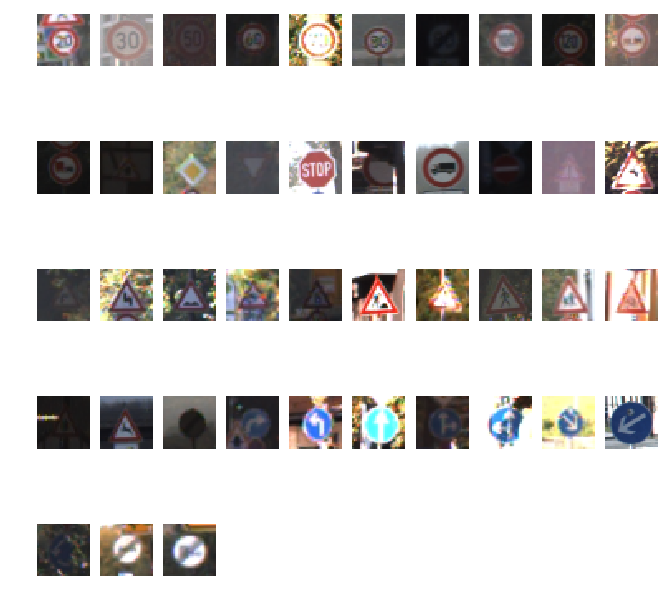

Preprocessed samples:


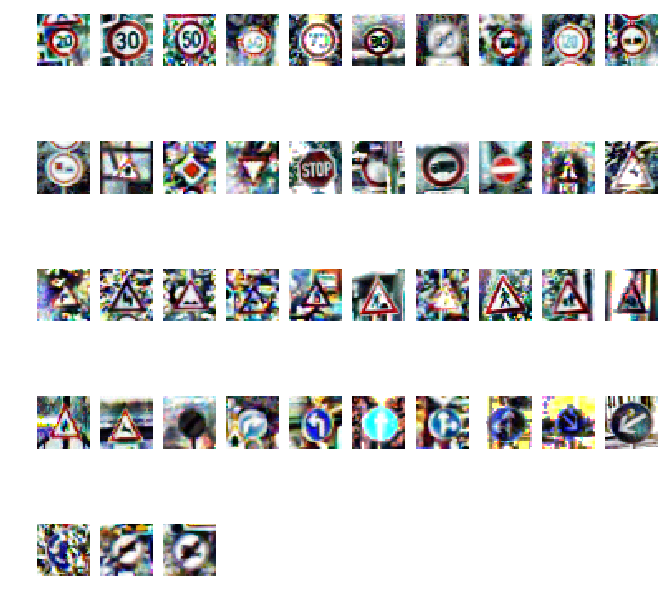

In [11]:
X_prep = preProcessData(X_train);
X_testPrep = preProcessData(X_test);

print('Original samples: ')
printClassSamples(X_train,y_train,1)
print('Preprocessed samples:')
printClassSamples(X_prep,y_train,1)

X_train = X_prep
X_test = X_testPrep

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

Data has been 0-1 normalized to scale the input vectors. 
Images should be normalized to help the computer vision to detect similar pictures more easily. Pictures taken consist of many parameter like saturation, brightness, size, position, which harden the identification task of same objects in different pictures. With normalizing we try to get similar means and standard deviations for images showing the same objects.

I choose to stick with colored images as described in Yann LeCunn's papers, it should be sufficient for this course to use colored images to get an accuracy of about 98%: http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf

"The system yielded the 2nd-best accuracy of 98.97% during
phase I of the competition (the best entry obtained 98.98%),
above the human performance of 98.81%, using 32x32 color
input images." 



Image Shape: (32, 32, 3)

Training Set:   31367 samples
Validation Set: 7842 samples
Test Set:       12630 samples


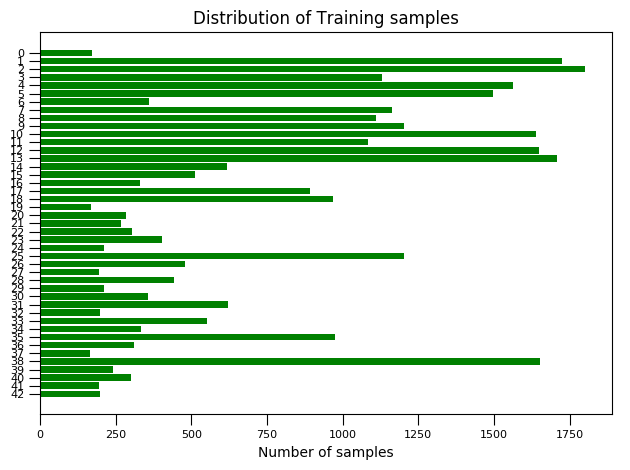

Maximum number of values on a class:  1800
Minimum number of values on a class:  163
Average number of values on a class:  729


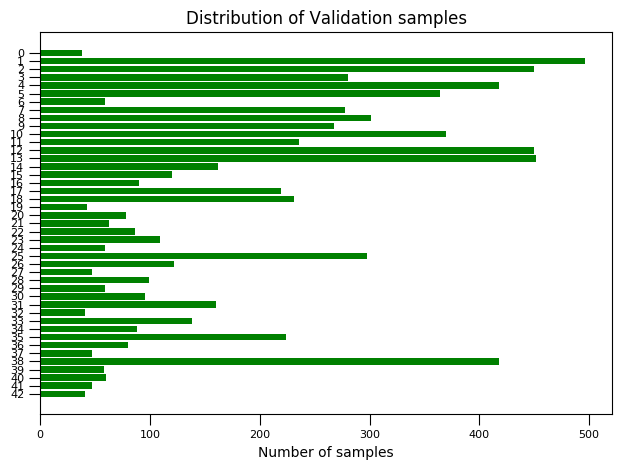

Maximum number of values on a class:  496
Minimum number of values on a class:  38
Average number of values on a class:  182


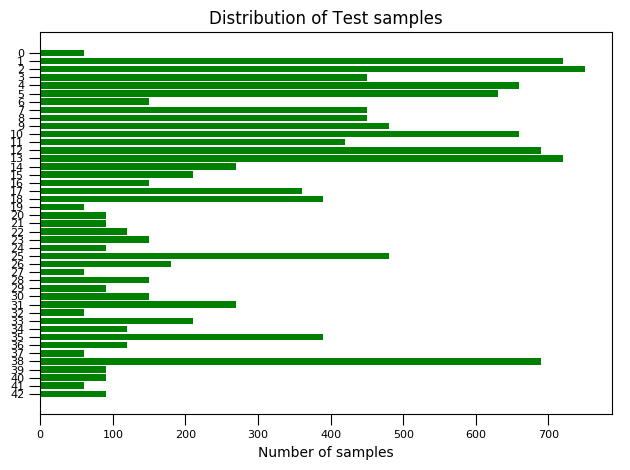

Maximum number of values on a class:  750
Minimum number of values on a class:  60
Average number of values on a class:  293


(60, 750, 293)

In [12]:
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

#use for small sample tests
sampleSizeFactor = 1.0

#Small sample
X_train = X_train[0:(int)(sampleSizeFactor*X_train.shape[0])]
y_train = y_train[0:(int)(sampleSizeFactor*y_train.shape[0])]

X_test = X_test[0:(int)(sampleSizeFactor*X_test.shape[0])]
y_test = y_test[0:(int)(sampleSizeFactor*y_test.shape[0])]

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

printDistribution(X_train,y_train, 'Training')
printDistribution(X_validation,y_validation, 'Validation')
printDistribution(X_test,y_test, 'Test')

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I created additional jittered images by shearing, rotating existing training images, as it turned out by checking the class distribution of the original dataset, that it's heavily unbalanced. 
So i first generated a balanced set of features with an equal number of all classes but those could only help for a few classes to get a higher detection rate, but if used for all, the detection rate actually decreased. So it confused the network more. I guess, that the transformation params i chose, were not sufficient enough to achieve a better training. So i disabled them in the end.

The validation set has been splitted from the training set with a factor of 0.2.

In [13]:
#Define graph functions for showing tensorboard within ipython

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [14]:
# Define layer functions

def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    print_activations(x)
    x = tf.nn.bias_add(x, b)
    tf.summary.histogram('pre_activations', x)
    print_activations(x)
    return x

def parametric_relu(_x):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1],
                       initializer=tf.constant_initializer(0.0),
                        dtype=tf.float32)
    pos = tf.nn.relu(_x)
    neg = alphas * (_x - abs(_x)) * 0.5

    return pos + neg

def activate(x, atype = 'relu', scope=None):
    temp = x
    if atype == 'relu':
        temp = tf.nn.relu(x, name=scope.name)
    elif atype == 'tanh':
        temp = tf.nn.tanh(x, name=scope.name)
    elif atype == 'prelu':   
        temp = parametric_relu(x)
    
    tf.summary.histogram('activations', temp)
    print_activations(temp)
    return temp

def maxpool2d(x, k=2):
    temp = tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')
    print_activations(temp)
    return temp

def dropout(hidden_layer, keep_prob = 0.5):
    tf.summary.scalar('dropout_keep_probability', keep_prob)
    temp = tf.nn.dropout(hidden_layer, keep_prob)
    print_activations(temp)
    return temp    

def batch_norm(x, ptrain, scope=None):
    with tf.variable_scope('bn'):
        batch_norm = tf.cond(ptrain, 
        lambda: tf.contrib.layers.batch_norm(x, activation_fn=tf.nn.relu, updates_collections=None, is_training=True, reuse=None, scope=scope),
        lambda: tf.contrib.layers.batch_norm(x, activation_fn =tf.nn.relu, updates_collections=None, is_training=False, reuse=True, scope=scope))
        tf.summary.histogram('batch_norm', batch_norm)
        return batch_norm

In [15]:
# Define workflow functions

def training(loss, learning_rate, global_step):
    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate)
    with tf.name_scope('training'):
        training_operation = optimizer.minimize(loss, global_step=global_step)
    return training_operation

def evaluation(y_pred, one_hot_y):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(one_hot_y, 1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)
    return accuracy

In [16]:
# Define model
def LeNet(x,ptrain, keep_prob, weights, biases, useBatch=True):    
    
    with tf.variable_scope('conv_1') as scope:
        # Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x8.
        conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
        
        variable_summaries(weights['layer_1'])
        variable_summaries(biases['layer_1'])

        #Batch norm
        if useBatch:
            conv1 = batch_norm(conv1, ptrain, scope)

        # Activation.
        conv1 = activate(conv1, 'relu', scope)

        # Pooling. Input = 30x30x8. Output = 15x15x8.
        pool1 = maxpool2d(conv1)

        #conv1 = dropout(pool1, keep_prob)

    with tf.variable_scope('conv_2') as scope:
        # Layer 2: Convolutional. Input = 15x15x8 Output = 11x11x16.
        conv2 = conv2d(pool1, weights['layer_2'], biases['layer_2'])

        variable_summaries(weights['layer_2'])
        variable_summaries(biases['layer_2'])
        
        #Batch norm
        if useBatch:
            conv2 = batch_norm(conv2, ptrain, scope)

        # Activation.
        conv2 = activate(conv2, 'relu', scope)

        # Pooling. Input = 11x11x16. Output = 5x5x16.
        pool2 = maxpool2d(conv2)

        #conv2 = dropout(pool2, keep_prob)
    
        # Flatten. Input = 5x5x16. Output = 400.  
        flatten_1 = flatten(pool2)
    
    with tf.variable_scope('fc_1') as scope:
        # Layer 3: Fully Connected. Input = 400. Output = 120.
        fc1 = tf.reshape(flatten_1,[-1, weights['fully_connected_1'].get_shape().as_list()[0]])
        fc1 = tf.add(tf.matmul(fc1, weights['fully_connected_1']),biases['fully_connected_1'])
        
        #Batch norm
        fc1 = batch_norm(fc1, ptrain, scope)
            
        fc1 = activate(fc1, 'tanh', scope)

        fc1 = dropout(fc1, keep_prob)
    
    with tf.variable_scope('fc_2') as scope:
        # Layer 4: Fully Connected. Input = 120. Output = 84.
        fc2 = tf.reshape(fc1,[-1, weights['fully_connected_2'].get_shape().as_list()[0]])
        fc2 = tf.add(tf.matmul(fc2, weights['fully_connected_2']),biases['fully_connected_2'])
        
        #Batch norm
        fc2 = batch_norm(fc2, ptrain, scope)
        
        fc2 = activate(fc2, 'tanh', scope)

        fc2 = dropout(fc2, keep_prob)

    with tf.variable_scope('fc_3') as scope:
        # Layer 5: Fully Connected. Input = 84. Output = 43.
        fc3 = tf.reshape(fc2,[-1, weights['fully_connected_3'].get_shape().as_list()[0]])
        fc3 = tf.add(tf.matmul(fc3, weights['fully_connected_3']),biases['fully_connected_3'])

        # Read out
        y_pred = tf.add(tf.matmul(fc3, weights['out']), biases['out'])
   
    print_activations(y_pred)
    
    return y_pred

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

## Using modified LeNet-5
[LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture modified with batch normalization and dropouts.

### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels.

### Architecture
**Layer 1: Convolutional.** 30, 30, 8

**Batch normalization.**  30, 30, 8

**Activation.**  30, 30, 8

**Pooling.** 15, 15, 8

**Layer 2: Convolutional.** 11, 11, 16

**Batch normalization.** 11, 11, 16

**Activation.** 11, 11, 16

**Pooling.** 5, 5, 16

**Flatten.** 400

**Layer 3: Fully Connected.** 120

**Activation.** 120

**Dropout.** 120

**Layer 4: Fully Connected.** 84

**Activation.** 84

**Dropout.** 84

**Layer 5: Fully Connected (Logits).** 43

<img src="main.PNG">
<img src="graph2.PNG">

In [17]:
# Reset graph
tf.reset_default_graph()
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))

# Hyperparameters
mu = 0
sigma = 0.1

n_classes = 43

layer_depth = {
    'layer_1': 8,
    'layer_2': 16,
    'fully_connected_1': 120,
    'fully_connected_2': 84,
    'fully_connected_3': 43
}

# Initialize layer weights
weights = {
    'layer_1': tf.Variable(tf.truncated_normal(
        [3, 3, 3, layer_depth['layer_1']], mean = mu, stddev = sigma), name='conv_layer_1'),
    'layer_2': tf.Variable(tf.truncated_normal(
        [5, 5, layer_depth['layer_1'], layer_depth['layer_2']], mean = mu, stddev = sigma), name='conv_layer_2'),
    'fully_connected_1': tf.Variable(tf.truncated_normal(
        [400, layer_depth['fully_connected_1']], mean = mu, stddev = sigma), name='fc_layer_1'),
    'fully_connected_2': tf.Variable(tf.truncated_normal(
        [120, layer_depth['fully_connected_2']], mean = mu, stddev = sigma), name='fc_layer_2'),
    'fully_connected_3': tf.Variable(tf.truncated_normal(
        [84, layer_depth['fully_connected_3']], mean = mu, stddev = sigma), name='fc_layer_3'),
    'out': tf.Variable(tf.truncated_normal(
        [layer_depth['fully_connected_3'], n_classes], mean = mu, stddev = sigma), name='read_out_layer')
}

# Initialize layer biases
biases = {
    'layer_1': tf.Variable(tf.zeros(layer_depth['layer_1']), name='bias_layer_1'),
    'layer_2': tf.Variable(tf.zeros(layer_depth['layer_2']),name='bias_layer_2'),
    'fully_connected_1': tf.Variable(tf.zeros(layer_depth['fully_connected_1']),name='bias_fc_1'),
    'fully_connected_2': tf.Variable(tf.zeros(layer_depth['fully_connected_2']),name='bias_fc_2'),
    'fully_connected_3': tf.Variable(tf.zeros(layer_depth['fully_connected_3']),name='bias_fc_3'),
    'out': tf.Variable(tf.zeros(n_classes),name='bias_read_out_layer')
}

In [18]:
### Train your model here.
import time
millis = int(round(time.time() * 1000))
CHKPT_FILE = 'checkpoints/my_cnn_' + str(millis) + '.ckpt'
LOG_DIR = 'summaries'

#reset tensorboard summaries for new run
#if tf.gfile.Exists(LOG_DIR):
#    tf.gfile.DeleteRecursively(LOG_DIR)
#tf.gfile.MakeDirs(LOG_DIR)

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
# GPU Issue: https://github.com/tensorflow/tensorflow/issues/6783
with tf.device('/cpu:0'):
    one_hot_y = tf.one_hot(y, n_classes)
    
ptrain = tf.placeholder(tf.bool, name='train')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

useBatch = True
# L2 Regularization rate
l2_beta = 0.001
# Early stopping loss
threshold=0.995
# Dropout keep probability
dropRate = 0.5
# Epochs to run
EPOCHS = 200
# Batch size
BATCH_SIZE = 32
#Total epoch size
epoch_size = 100000

# Variable for remembering the steps
global_step = tf.Variable(0, name='global_step', trainable=False)

# Initialize decaying learning rate
learning_rate = tf.train.exponential_decay(
  0.001,                # Base learning rate.
  global_step * BATCH_SIZE,  # Current index into the dataset.
  epoch_size,          # Decay step.
  0.95,                # Decay rate.
  staircase=True)

# Prediction function
y_pred = LeNet(x,ptrain,keep_prob, weights, biases, useBatch)

# Loss function
with tf.name_scope('cross_entropy'):
    diff = tf.nn.softmax_cross_entropy_with_logits(y_pred, one_hot_y)
    with tf.name_scope('total'):
        cross_entropy = tf.reduce_mean(diff)
tf.summary.scalar('cross_entropy', cross_entropy)

# Add l2 regularization to the loss
with tf.name_scope('L2_reg'):
    for key in list(weights.keys()):
        cross_entropy += l2_beta * tf.nn.l2_loss(weights[key])

# Update weights
with tf.name_scope('train'):
    train_step = training(cross_entropy, learning_rate, global_step)

# Evaluate prediction accuracy
with tf.name_scope('accuracy'):
    accuracy = evaluation(y_pred, one_hot_y)
    
# Merge all the summaries and write them out
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(LOG_DIR + '/train',
                                      sess.graph)
val_writer = tf.summary.FileWriter(LOG_DIR + '/validation',
                                      sess.graph)
test_writer = tf.summary.FileWriter(LOG_DIR + '/test',
                                      sess.graph)
tf.global_variables_initializer().run()

conv_1/Conv2D   [None, 30, 30, 8]
conv_1/BiasAdd   [None, 30, 30, 8]
conv_1/conv_1   [None, 30, 30, 8]
conv_1/MaxPool   [None, 15, 15, 8]
conv_2/Conv2D   [None, 11, 11, 16]
conv_2/BiasAdd   [None, 11, 11, 16]
conv_2/conv_2   [None, 11, 11, 16]
conv_2/MaxPool   [None, 5, 5, 16]
fc_1/fc_1   [None, 120]
fc_1/dropout/mul   [None, 120]
fc_2/fc_2   [None, 84]
fc_2/dropout/mul   [None, 84]
fc_3/Add_1   [None, 43]


In [19]:
vars_to_train = tf.trainable_variables()
vars_for_bn1 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES , scope='conv_1/bn')
vars_for_bn2 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES , scope='conv_2/bn')
vars_to_train = list(set(vars_to_train).union(set(vars_for_bn1)))
vars_to_train = list(set(vars_to_train).union(set(vars_for_bn2)))

In [20]:
import os
TASK = 'train' # 'train' or 'test'

if TASK == 'test' and os.path.exists(CHKPT_FILE):
    restore_call = True
    vars_all = tf.all_variables()
    vars_to_init = list(set(vars_all) - set(vars_to_train))
    init = tf.global_variables_initializer(vars_to_init)
elif TASK == 'train':
    restore_call = False
    init = tf.global_variables_initializer()
else:
    print('please set TASK to either train or test')

saver = tf.train.Saver(vars_to_train)

In [21]:

#sess.run(init)
with tf.device('/gpu:0'):
    if restore_call:
        # Restore variables from disk.
        saver.restore(sess, CHKPT_FILE) 

    if TASK == 'train':
        #sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)

        print("Training on ", num_examples, ' examples')
        print()
        lastAccuracy = 0

        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)

            if threshold < lastAccuracy:
                print('Stopping training, threshold accuracy of ', threshold, ' reached!') 
                break;

            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                summary, _ = sess.run([merged, train_step], feed_dict={x: batch_x, y: batch_y, ptrain: True, keep_prob: dropRate})
                train_writer.add_summary(summary, offset)

                if offset % num_examples/BATCH_SIZE == 0:
                    cv_fd = {x: X_validation, y: y_validation, ptrain: False, keep_prob: 1.0}
                    summary, train_accuracy = sess.run([merged, accuracy], feed_dict=cv_fd)
                    val_writer.add_summary(summary, offset)

                    train_loss = cross_entropy.eval(cv_fd)
                    #train_accuracy = acc.eval(cv_fd)
                    print('Learning Rate:', learning_rate.eval(), ', Global Step: ', global_step.eval())
                    print('EPOCH {}'.format(i+1),', Loss: %8.4f, Validation Accuracy = %8.4f' % (train_loss, train_accuracy))
                    lastAccuracy = train_accuracy


        save_path = saver.save(sess, CHKPT_FILE)
        print("Model saved in file: %s" % save_path)

Training on  31367  examples

Learning Rate: 0.001 , Global Step:  1
EPOCH 1 , Loss:   4.0153, Validation Accuracy =   0.0509
Learning Rate: 0.001 , Global Step:  982
EPOCH 2 , Loss:   1.5957, Validation Accuracy =   0.6408
Learning Rate: 0.001 , Global Step:  1963
EPOCH 3 , Loss:   1.1787, Validation Accuracy =   0.7047
Learning Rate: 0.001 , Global Step:  2944
EPOCH 4 , Loss:   0.6627, Validation Accuracy =   0.8771
Learning Rate: 0.00095 , Global Step:  3925
EPOCH 5 , Loss:   0.5096, Validation Accuracy =   0.9269
Learning Rate: 0.00095 , Global Step:  4906
EPOCH 6 , Loss:   0.4522, Validation Accuracy =   0.9495
Learning Rate: 0.00095 , Global Step:  5887
EPOCH 7 , Loss:   0.4112, Validation Accuracy =   0.9569
Learning Rate: 0.0009025 , Global Step:  6868
EPOCH 8 , Loss:   0.4055, Validation Accuracy =   0.9561
Learning Rate: 0.0009025 , Global Step:  7849
EPOCH 9 , Loss:   0.3660, Validation Accuracy =   0.9699
Learning Rate: 0.0009025 , Global Step:  8830
EPOCH 10 , Loss:   0.37

In [22]:
#Test
with tf.name_scope('testing'):
    #test set is already preprocessed
    num_examples = len(X_test)
    accs = []
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = X_test[offset:end], y_test[offset:end]

        test_fd = {x: batch_x, y: batch_y, ptrain: False, keep_prob: 1.0}
        summary, test_accuracy = sess.run([merged, accuracy], feed_dict=test_fd)
        test_writer.add_summary(summary, offset)
        accs.append(test_accuracy)

    print("Test Accuracy = {:.3f}".format(np.mean(accs)))

Test Accuracy = 0.966


In [23]:
'''
#inline tensorboard graph
gdef = tf.GraphDef()
from google.protobuf import text_format
text_format.Merge(open("tf_persistent.pbtxt").read(), gdef)
show_graph(gdef)
'''

'\n#inline tensorboard graph\ngdef = tf.GraphDef()\nfrom google.protobuf import text_format\ntext_format.Merge(open("tf_persistent.pbtxt").read(), gdef)\nshow_graph(gdef)\n'

Below is the tensorboard graph of the test accuracy and loss:

<img src="testacc.PNG">

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

Within 20 Epochs and a batch size of 32 the accuracy went above 98% with a loss of 0.2975. 
The loss has been cut by half after additional 180 epochs, lifting the validatio accuracy to 99,31% and loss to 0.1549.

As starter learning rate 0.001 is chosen, all others resolve in a huge decrease on accuracy.
The learning rate is decayed by 0.95.

The training set is shuffled per epoch.

The probability errors are measured with softmax_cross_entropy_with_logits. and the loss is L2 regularized.
As optimizer the SDG variant Adam has been chosen as it was on the LeNet implementation of the lessons.

mean of 0 and a stddev of 0.1 as recommended in the lessons papers.

Dropouts have been attached to the fully connected layers with a keep probality of 0.5 and batch normalization to the conv layers.

Early stopping is applied after reaching a training threshold.

Example runs:
Validation Accuracy =   0.9931, Test Accuracy = 0.966, New captured accuracy = 0.5


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

The starting point was the LeNet architecture from the lessons which already gave about 90% validation accuracy but only 56% test accuracy. So i went on to find out the cause by starting from the top on data preprocessing. 

I balanced out the test data with jittered images which did not really improve the results that much, at least not on the current params.

after a mentor talk, I applied 0-1 normalization. which lifted the validation accuracy to 97% but still bad test accuracy of 70%. Also the fixed learning rate was turned into an exponential decay to decrease the learning rate step by step. So 98,4% of validation accuracy was achieved,  with about 88% test accuracy.

adding dropout to the fully connected layers and batch normalization to conv layers lifted the test accuracy finally over 95%, based on descriptions found here:
https://www.quora.com/Why-does-batch-normalization-help
https://pgaleone.eu/deep-learning/regularization/2017/01/10/anaysis-of-dropout/
Dropout has been enabled only for training.






---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [24]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
'''
ClassId	SignName
0	Speed limit (20km/h)
1	Speed limit (30km/h)
2	Speed limit (50km/h)
3	Speed limit (60km/h)
4	Speed limit (70km/h)
5	Speed limit (80km/h)
6	End of speed limit (80km/h)
7	Speed limit (100km/h)
8	Speed limit (120km/h)
9	No passing
10	No passing for vechiles over 3.5 metric tons
11	Right-of-way at the next intersection
12	Priority road
13	Yield
14	Stop
15	No vechiles
16	Vechiles over 3.5 metric tons prohibited
17	No entry
18	General caution
19	Dangerous curve to the left
20	Dangerous curve to the right
21	Double curve
22	Bumpy road
23	Slippery road
24	Road narrows on the right
25	Road work
26	Traffic signals
27	Pedestrians
28	Children crossing
29	Bicycles crossing
30	Beware of ice/snow
31	Wild animals crossing
32	End of all speed and passing limits
33	Turn right ahead
34	Turn left ahead
35	Ahead only
36	Go straight or right
37	Go straight or left
38	Keep right
39	Keep left
40	Roundabout mandatory
41	End of no passing
42	End of no passing by vechiles over 3.5 metric tons
'''

def printPredictions(X_new,X_prep,top,k,y_prep):
    
    for index in range(len(X_new)):
        original = X_new[index]
 
        plt.figure(figsize = (6, 2))
        gridspec.GridSpec(2, 2)

        plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
        plt.title('new image',fontsize= 10)
        plt.imshow(original)
        plt.axis('off')
        
        preprocessed = X_prep[index]

        plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
        plt.title('preprocessed',fontsize= 10)
        plt.imshow(preprocessed)
        plt.axis('off')

        plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=2)
        plt.title(class_data[y_prep[index]],fontsize= 10)
        plt.barh(np.arange(5)+.5, top[0][index], align='center')
        plt.yticks(np.arange(5)+.5, class_data[top[1][index].astype(int)])
        plt.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='on')
    
    plt.show()

def readNewImages(filenames):
    images = []
    for name in filenames:
        img = cv2.imread(name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return np.array(images)

with tf.name_scope('new_images'):
    y_prep = np.array([3,14,23,36,17,5,13,18,4,21,35,12])
    filenames = ["new/274.png","new/206.png","new/114.png","new/214.png","new/267.png"
                ,"new/80.jpeg" ,"new/yield.jpeg" ,"new/attention.jpeg" ,"new/70.jpeg" ,"new/s-curve.jpeg"
                 ,"new/straight.jpeg" ,"new/priority.jpeg"]
    X_new = readNewImages(filenames)
    X_prep = preProcessData(X_new)

Sample image pixel before:  [255 255 255]
Sample image pixel after:  [ 1.  1.  1.]


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I've chosen 5 simple non real world examples and 7 real world examples. The real world examples are though to identify as some are partly concealed, from bad quality and containing additional signs next to the traffic sign itself.
This will likely mislead the network.

In [25]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
with tf.name_scope('predict_probabilities'):
    saver.restore(sess, CHKPT_FILE)
    new_fd = {x: X_prep, y: y_prep, ptrain: False, keep_prob: 1.0}
    new_accuracy = sess.run(accuracy, feed_dict=new_fd)
    print("New Accuracy = {:.3f}".format(new_accuracy))

    pred_probabilities = sess.run(tf.nn.softmax(y_pred), new_fd)
    pred_flat = np.max(pred_probabilities, axis=1).tolist()
    print('1st Prediction Probabilities: ', pred_flat)

New Accuracy = 0.500
1st Prediction Probabilities:  [0.9155062437057495, 0.9814440011978149, 0.7254717350006104, 0.995830237865448, 0.9999567270278931, 0.3926631808280945, 0.20880846679210663, 0.42056339979171753, 0.5770781636238098, 0.5364499092102051, 0.4204600751399994, 0.9998705387115479]


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

Accuraccy on new images varied from 50% to 75% depending on the overall feature size and quality chosen for multiple runs.
That the augmentation is not the best can easily be seen because the model has a lot of problems on captured pictures, wheras clean pictures with only traffic signs are 100% accurately detected all the time (see first 5 images below).

On the third image 'slippery road' the confidence is lower because the network found more similiar looking traffic signs.

On the second last image ahead only the predictions are really spreading out and prediction traffic signs which are from total different shape than the image shown. Thus it's likely that we overfit somewhere.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

**Answer:**

Top 5 predictions:


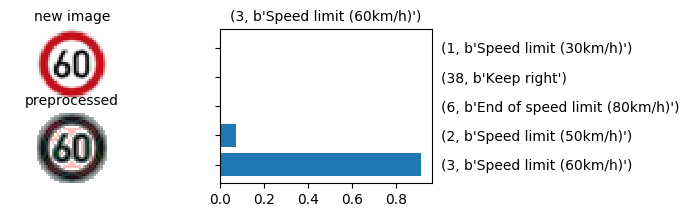

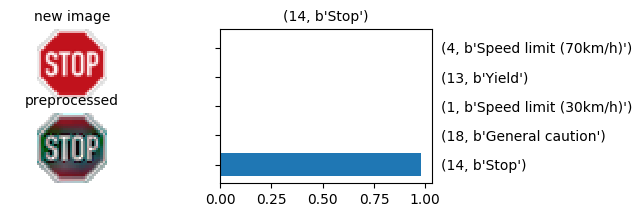

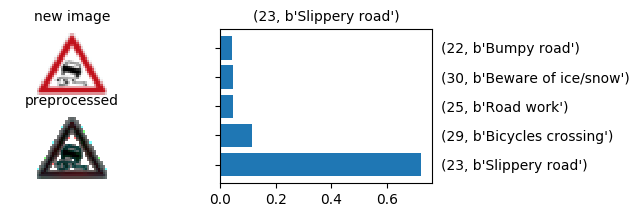

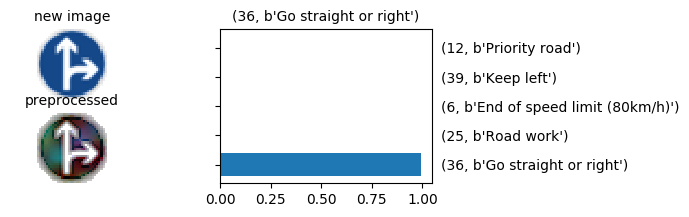

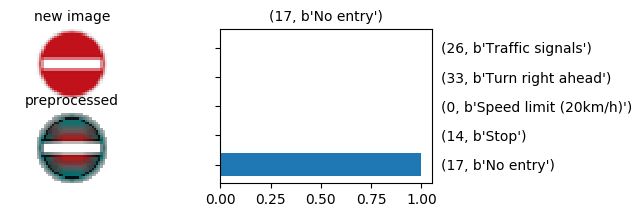

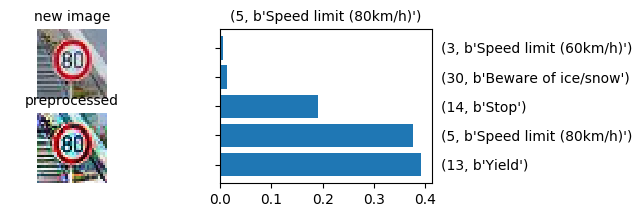

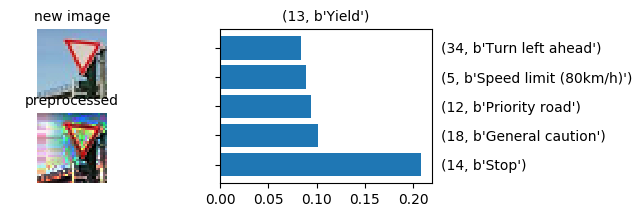

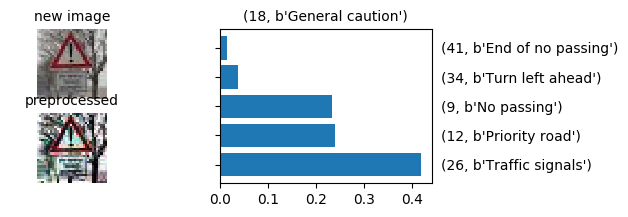

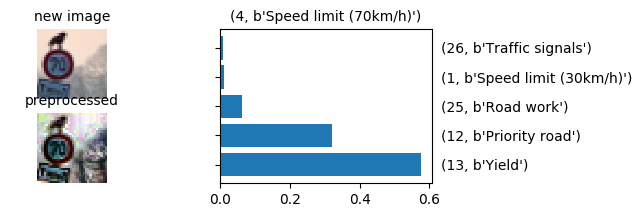

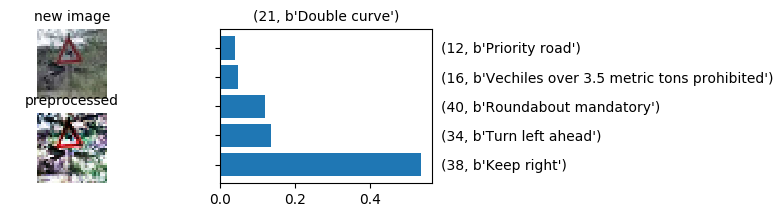

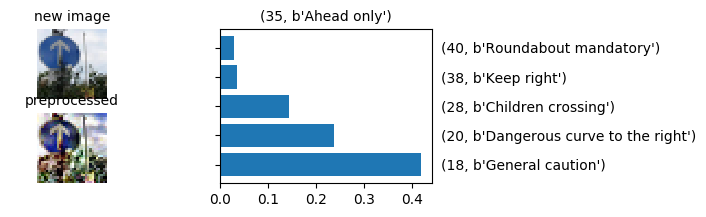

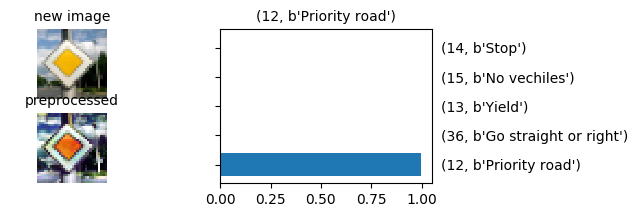

In [27]:
with tf.name_scope('ktop_probabilities'):
    saver.restore(sess, CHKPT_FILE)
    top = sess.run(tf.nn.top_k(tf.constant(pred_probabilities), k=5))
    print('Top 5 predictions:')
    printPredictions(X_new,X_prep,top,5,y_prep)

    #Graphical view
    """
    my_new = np.array([
    3,14,23,36,17,5,13,18,4,21,35,12])
    """

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.